In [1]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root="data/Cora", name="Cora", transform=NormalizeFeatures())
len(dataset)
data = dataset[0]

In [11]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [14]:
import torch
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F

In [24]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.linear1 = Linear(input_dim, hidden_channels)
        self.linear2 = Linear(hidden_channels, num_classes)
    
    def forward(self, x):
        x = self.linear1(x)
        #x = nn.ReLU(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        
        return x

model = MLP(input_dim=dataset.num_features, hidden_channels=16, 
           num_classes=dataset.num_classes)
        
print(model)        

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)


In [25]:
model = MLP(input_dim=dataset.num_features, hidden_channels=16, 
           num_classes=dataset.num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 5e-4)

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss

def test(data):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [27]:
test_acc = test(data)
print(f'Test accuracy : {test_acc:.2f}')

Test accuracy : 0.59


In [36]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(in_channels=dataset.num_features, out_channels=hidden_channels)
        self.gcn2 = GCNConv(in_channels=hidden_channels, out_channels=dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gcn2(x, edge_index)
        return x

model = GCN(dataset, hidden_channels=16 )
print(model)    
        

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


In [37]:
model.eval()

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)

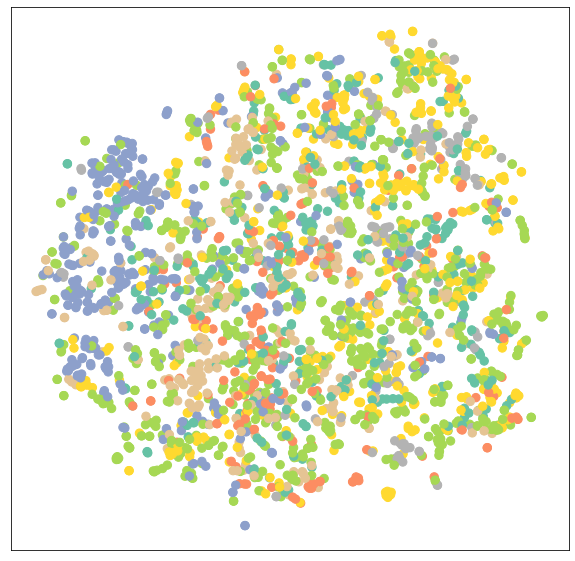

In [38]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [51]:
model = GCN(dataset, hidden_channels=16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,
                             weight_decay=5e-4)

def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss

def test(data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int (data.test_mask.sum())
    return test_acc

for epoch in range( 201):
    loss = train(data)
    if epoch % 25 == 0:
        print(f'Epoch: {epoch:d}, loss: {loss:.2f}')
test_acc = test(data)
print(f'\n Test acc: {test_acc:.2f}')

Epoch: 0, loss: 1.95
Epoch: 25, loss: 1.61
Epoch: 50, loss: 1.13
Epoch: 75, loss: 0.70
Epoch: 100, loss: 0.58
Epoch: 125, loss: 0.45
Epoch: 150, loss: 0.41
Epoch: 175, loss: 0.36
Epoch: 200, loss: 0.35

 Test acc: 0.81


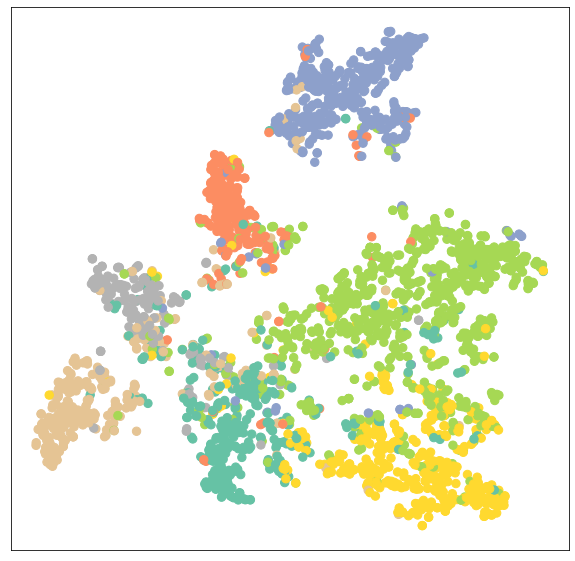

In [48]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)